In [1]:
# Basic NN for TSURF-HW
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#ML
from keras.models import Sequential
from keras.layers import Dense
import keras.layers as layers
import keras
import keras_metrics
import innvestigate
import tensorflow as tf

import warnings

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Optionally, suppress warnings in general
warnings.filterwarnings("ignore")

np.random.seed(20)

Using TensorFlow backend.


### Input data

In [2]:
# Read 2mT field
tas_data = xr.open_dataset('/work/uo1075/u301680/all_member/test/europe_djf_final.nc') # detrend


# # Select data from 1850 to 2013
tas_winter = tas_data.sel(time=slice("1851-01-16T12:00:00.00000000", "2014-01-16T12:00:00.000000000"))

# Store the winter 2mT data into input_data variable
input_data = tas_winter

input_data = input_data.isel(bnds=0)

input_data = input_data.tas

# Get the size of latitude and longitude
lat_size = input_data.lat.size#24
lon_size = input_data.lon.size#37

# Calculate time series by reshaping data
input_data_timeseries = input_data.values.reshape(input_data.shape[0]*input_data.shape[1],input_data.shape[2]*input_data.shape[3])

# Store reshaped data into input_vect
input_vect = input_data_timeseries

# Normalize the input_vect
mx = input_vect.mean(axis=0)
sx = input_vect.std(axis=0)
X_all = (input_vect - input_vect.mean(axis=0))/input_vect.std(axis=0)

# Fill any NaN values with zero 
X_all = np.where(np.isnan(X_all),0,X_all)
#X_all = np.where(np.isnan(input_vect),0,input_vect)

In [3]:
X_all.shape

(8200, 513)

### Target data

In [4]:
# Read SST field
tos_data = xr.open_dataset('/work/uo1075/u301680/all_member/test/north_atlantic_son_final.nc') # detrend

# Select data from 1850 to 2013
tos_autumn = tos_data.sel(time=slice('1851-10-16T12:00:00.000000000', '2014-10-16T12:00:00.000000000'))

# Store the autumn data into hw_exceed variable
hw_exceed = tos_autumn

hw_exceed = hw_exceed.isel(bnds=0)

hw_exceed = hw_exceed.tos
# # vectorize the data
# # hw_exceed_timeseries = hw_exceed.values.reshape(hw_exceed.shape[0]*hw_exceed.shape[1],hw_exceed.shape[2],hw_exceed.shape[3])

# #Sum over north atlantic
hw_exceed_north_atlantic = np.sum(hw_exceed,axis=2)
hw_exceed_north_atlantic = np.sum(hw_exceed_north_atlantic,axis=2)

#vectorize
hw_exceed_north_atlantic_timeseries = hw_exceed_north_atlantic.values.reshape(-1)

# Calculate the sample mean
sample_mean = hw_exceed_north_atlantic_timeseries.mean()

# Classify data: 1 for values greater than or equal to the mean, 0 for values below the mean
classification = (hw_exceed_north_atlantic_timeseries >= sample_mean).astype(int)

# One-hot encoding for Keras
Y_all = keras.utils.to_categorical(classification)
Y_all.shape

(8200, 2)

In [5]:
# Summing over axis 0 to count the number of occurrences of each class
counts = np.sum(Y_all, axis=0)

print(f"Number of samples for class 0: {counts[0]}")
print(f"Number of samples for class 1: {counts[1]}")

Number of samples for class 0: 4126.0
Number of samples for class 1: 4074.0


## ML part

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(X_all, Y_all, test_size=0.2, random_state=1, shuffle=True)

#Calculate the number of inputs
number_inputs = X_train.shape[-1]

#Calculate number of classes
num_classes = len(np.unique(classification))

seed_number = 55 

#Nodes
number_nodes_layer_one = 10 #number of nodes of layer one
#number_nodes_layer_two = 40 #number of nodes of layer two (needed if layer two exists)

#Regularization
l1_regularization_layer_one = 0
l2_regularization_layer_one = 2 #regularization to avoid overfitting, higher the value, less overfit, more underfit 

# l1_regularization_layer_two = 0
# l2_regularization_layer_two = 0

l1_regularization_layer_three = 0
l2_regularization_layer_three = 0
# Best: nan using {'optimizer': 'sgd', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 128, 'activation': 'relu'}

#Learning rate
learning_rate = 0.001 # best - 0.0001

batch_size = 32 # best - 32
epochs = 100 
shuffle = True 
verbose = 2 #(0 = no output; 2 = output accuracy every epoch)

model = keras.models.Sequential([ \

    keras.layers.Dense(number_nodes_layer_one, input_shape=(int(number_inputs),), 
                       use_bias=True, activation='relu',
                       kernel_initializer=keras.initializers.he_normal(seed=seed_number), bias_initializer=keras.initializers.ones(),
                       kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_one, l2=l2_regularization_layer_one)),
       
    # keras.layers.Dense(number_nodes_layer_two, activation='relu', use_bias=True,
    #                     kernel_initializer=keras.initializers.glorot_normal(seed=seed_number), bias_initializer=keras.initializers.he_normal(seed=seed_number), 
    #                     kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_two, l2=l2_regularization_layer_two)),
          
    keras.layers.Dense(num_classes, use_bias=True, 
                       kernel_initializer=keras.initializers.he_normal(seed=seed_number), bias_initializer=keras.initializers.ones(), 
                       kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_three, l2=l2_regularization_layer_three)),                                                                           

    keras.layers.Activation('softmax') 
                      ])   
    
opt = keras.optimizers.SGD(lr=learning_rate, momentum=0, nesterov=False, decay=0)
#opt = keras.optimizers.Adam(lr=learning_rate, decay=0)

model.compile(optimizer=opt,
              loss = 'categorical_crossentropy', 
              metrics=[keras.metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall(),
                      keras_metrics.f1_score()])

#model.summary()

#Early Stop
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

###Train the neural network!
history = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), 
      batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose 
      ,callbacks=callback)


Train on 6560 samples, validate on 1640 samples
Epoch 1/100
 - 0s - loss: 20.8693 - categorical_accuracy: 0.5508 - precision: 0.6493 - recall: 0.2338 - f1_score: 0.3438 - val_loss: 8.5548 - val_categorical_accuracy: 0.5951 - val_precision: 0.6923 - val_recall: 0.3495 - val_f1_score: 0.4645
Epoch 2/100
 - 0s - loss: 4.5437 - categorical_accuracy: 0.6146 - precision: 0.6778 - recall: 0.4467 - f1_score: 0.5385 - val_loss: 2.1858 - val_categorical_accuracy: 0.6220 - val_precision: 0.6518 - val_recall: 0.5316 - val_f1_score: 0.5856
Epoch 3/100
 - 0s - loss: 1.4068 - categorical_accuracy: 0.6349 - precision: 0.6556 - recall: 0.5787 - f1_score: 0.6148 - val_loss: 0.9577 - val_categorical_accuracy: 0.6262 - val_precision: 0.6341 - val_recall: 0.6056 - val_f1_score: 0.6195
Epoch 4/100
 - 0s - loss: 0.8019 - categorical_accuracy: 0.6405 - precision: 0.6464 - recall: 0.6311 - f1_score: 0.6387 - val_loss: 0.7243 - val_categorical_accuracy: 0.6220 - val_precision: 0.6275 - val_recall: 0.6092 - val_

In [7]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from sklearn.model_selection import RandomizedSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

# def build_model(activation='relu', optimizer='adam', learning_rate=0.001):
#     model = keras.models.Sequential([
#         keras.layers.Dense(10, input_shape=(number_inputs,), 
#                            use_bias=True, activation=activation,
#                            kernel_initializer=keras.initializers.he_normal(seed=seed_number), 
#                            bias_initializer=keras.initializers.ones(),
#                            kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=2)),
        
#         keras.layers.Dense(num_classes, use_bias=True, 
#                            kernel_initializer=keras.initializers.he_normal(seed=seed_number), 
#                            bias_initializer=keras.initializers.ones(), 
#                            kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0)),
        
#         keras.layers.Activation('softmax')
#     ])
    
#     # Set optimizer
#     if optimizer == 'adam':
#         opt = keras.optimizers.Adam(lr=learning_rate, decay=0)
#     elif optimizer == 'sgd':
#         opt = keras.optimizers.SGD(lr=learning_rate, momentum=0, nesterov=False, decay=0)
#     else:
#         opt = keras.optimizers.RMSprop(lr=learning_rate, decay=0)

#     model.compile(optimizer=opt,
#                   loss='categorical_crossentropy', 
#                   metrics=[keras.metrics.categorical_accuracy])
    
#     return model


# param_dist = {
#     'batch_size': [16, 32, 64, 128],
#     'epochs': [100, 200, 300],
#     'activation': ['relu', 'tanh'],
#     'optimizer': ['adam', 'sgd', 'rmsprop'],
#     'learning_rate': [0.001, 0.01, 0.0001]
# }

# model1 = KerasClassifier(build_fn=build_model, verbose=0)

# random_search = RandomizedSearchCV(estimator=model1, 
#                                    param_distributions=param_dist, 
#                                    n_iter=10, # Number of random configurations to try
#                                    scoring='accuracy', 
#                                    cv=3, # 3-fold cross-validation
#                                    verbose=2, 
#                                    n_jobs=-1) # Use all available cores


# random_search_result = random_search.fit(X_train, Y_train)

# print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

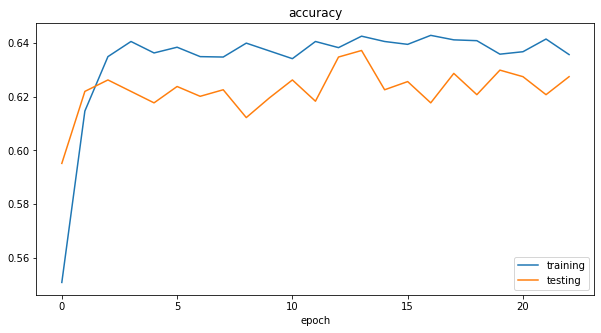

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history.history['categorical_accuracy'],label = 'training')
plt.plot(history.history['val_categorical_accuracy'], label = 'testing')
plt.title('accuracy')
plt.xlabel('epoch')
# plt.xticks(epoch_label)
plt.legend()
plt.show()

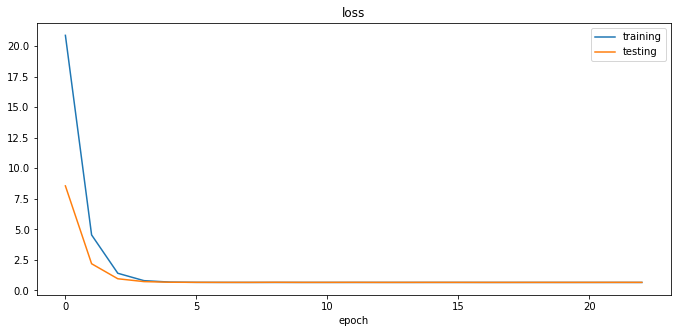

In [9]:
# Plot loss curve
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.title('loss')
plt.xlabel('epoch')
#plt.xticks(epoch_label)
plt.legend()
plt.show()

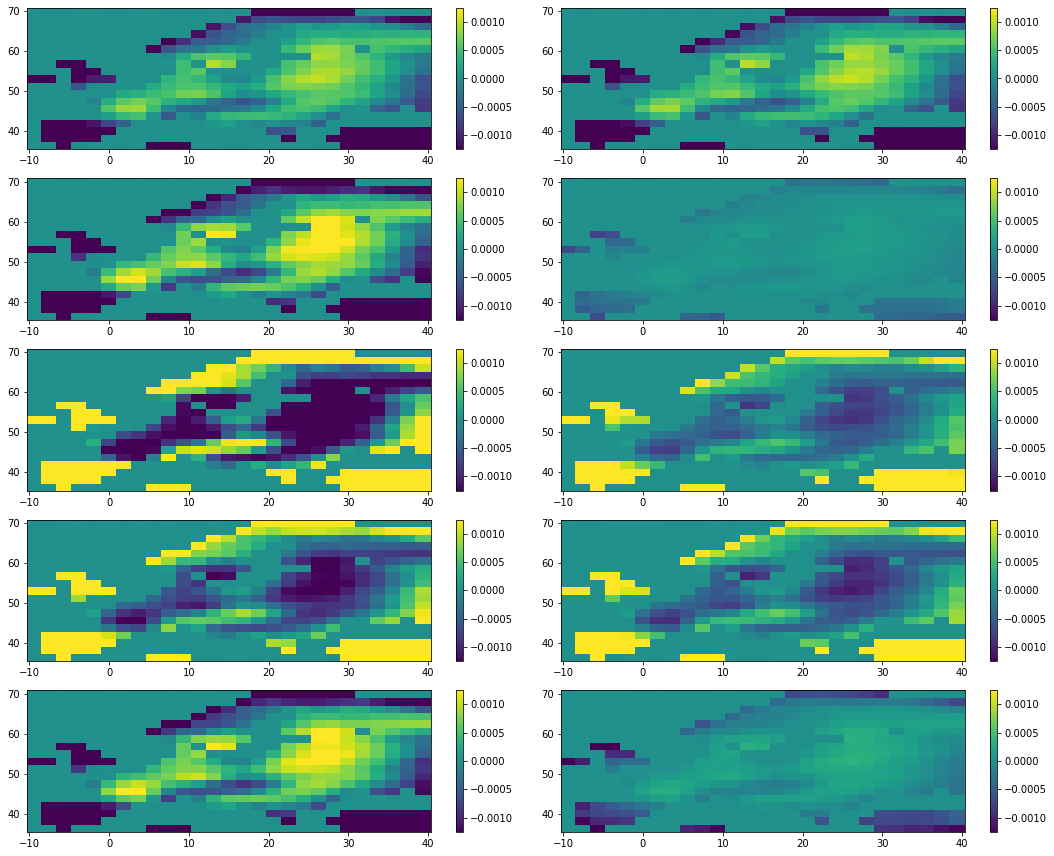

In [10]:
# plot weights
layer_weights, layer_biases = model.layers[0].get_weights()
layers_1 = layer_weights.T
layers_1 = layers_1.reshape(layers_1.shape[0], lat_size, lon_size)

# Number of rows and columns
rows, cols = 5, 2

# Create a figure and a set of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

# Loop through each layer and plot the weights
for i in range(layers_1.shape[0]):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    c = ax.pcolormesh(tas_winter.lon, tas_winter.lat, layers_1[i,:,:], shading='auto', vmin=-0.00125, vmax=0.00125, cmap='viridis')
    #ax.set_title(f'Layer {i+1} Weights')
    fig.colorbar(c, ax=ax)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
model_probability = model.predict(X_validation)

y_predict_validation = np.zeros((model_probability.shape[0],model_probability.shape[1]))
for i in range(model_probability.shape[0]):
    y_predict_validation[i,:] = (model_probability[i,:] == np.max(model_probability[i,:])).astype(np.int)

cm = confusion_matrix(Y_validation.argmax(axis=1), y_predict_validation.argmax(axis=1))
print(cm)

[[521 303]
 [308 508]]


### LRP & Pattern

In [12]:
model_nosoftmax = innvestigate.utils.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer('deep_taylor', model_nosoftmax)

sat_tp_cl1 = []
sat_tp_cl2 = []

LRP_heatmaps_tp_cl1 = []
LRP_heatmaps_tp_cl2 = []

for sample_ind, sample in enumerate(X_validation):         
    if (Y_validation[sample_ind,0] == 1)&(y_predict_validation[sample_ind,0]==1):
        sat_tp_cl1.append(sample[np.newaxis,...])
        LRP_heatmap = analyzer.analyze(sample[np.newaxis,...])
        LRP_heatmaps_tp_cl1.append(LRP_heatmap)
        
    if (Y_validation[sample_ind,1] == 1)&(y_predict_validation[sample_ind,1]==1):
        sat_tp_cl2.append(sample[np.newaxis,...])
        LRP_heatmap = analyzer.analyze(sample[np.newaxis,...])
        LRP_heatmaps_tp_cl2.append(LRP_heatmap)


In [13]:
# Lrp heatmaps for true negative and positive class
LRP_heatmaps_tp_cl1 = np.array(LRP_heatmaps_tp_cl1)
LRP_heatmaps_tp_cl2 = np.array(LRP_heatmaps_tp_cl2)

# Normalize Lrp
LRP_heatmaps_tp_cl1 = LRP_heatmaps_tp_cl1/np.max(LRP_heatmaps_tp_cl1, axis=(-2,-1))[:,np.newaxis,np.newaxis]
LRP_heatmaps_tp_cl2 = LRP_heatmaps_tp_cl2/np.max(LRP_heatmaps_tp_cl2, axis=(-2,-1))[:,np.newaxis,np.newaxis]

# insert lat/lon dimensions to convert the vectorized file into the original grid!
LRP_heatmaps_tp_cl1 = LRP_heatmaps_tp_cl1.reshape(LRP_heatmaps_tp_cl1.shape[0], lat_size, lon_size)
LRP_heatmaps_tp_cl2 = LRP_heatmaps_tp_cl2.reshape(LRP_heatmaps_tp_cl2.shape[0], lat_size, lon_size)

# Comppsite of heatmap
LRP_heatmaps_tp_cl1_mean = np.nanmean(LRP_heatmaps_tp_cl1, axis=0)
LRP_heatmaps_tp_cl2_mean = np.nanmean(LRP_heatmaps_tp_cl2, axis=0)

LRP_heatmaps_tp_mean = np.zeros((2,LRP_heatmaps_tp_cl1_mean.shape[0],LRP_heatmaps_tp_cl1_mean.shape[1]))

LRP_heatmaps_tp_mean[0,:,:] = LRP_heatmaps_tp_cl1_mean
LRP_heatmaps_tp_mean[1,:,:] = LRP_heatmaps_tp_cl2_mean

LRP_heatmaps_tp_mean = np.where(LRP_heatmaps_tp_mean==0,np.nan,LRP_heatmaps_tp_mean)

In [14]:
# SAT pattern for true negative and positive class
sat_tp_cl1 = np.array(sat_tp_cl1)
sat_tp_cl2 = np.array(sat_tp_cl2)

sat_tp_cl1_ice = sat_tp_cl1.reshape(sat_tp_cl1.shape[0], lat_size, lon_size)
sat_tp_cl2_ice = sat_tp_cl2.reshape(sat_tp_cl2.shape[0], lat_size, lon_size)

# Composite of pattern
sat_tp_cl1_mean = np.nanmean(sat_tp_cl1_ice, axis=0)
sat_tp_cl2_mean = np.nanmean(sat_tp_cl2_ice, axis=0)

sat_tp_mean = np.zeros((2,sat_tp_cl1_mean.shape[0],sat_tp_cl1_mean.shape[1]))

sat_tp_mean[0,:,:] = sat_tp_cl1_mean
sat_tp_mean[1,:,:] = sat_tp_cl2_mean

sat_tp_mean = np.where(sat_tp_mean==0,np.nan,sat_tp_mean)

### SAT pattern

0
1


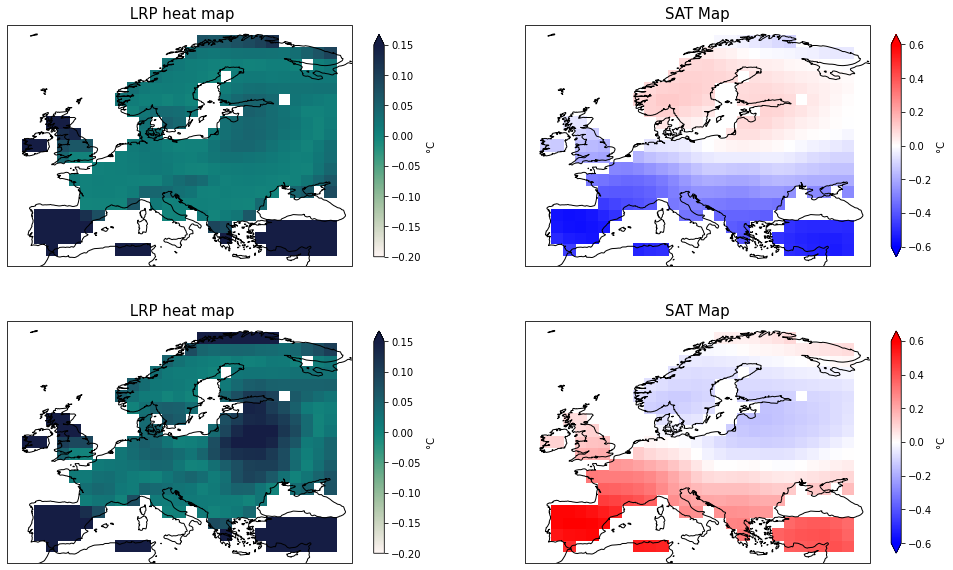

In [16]:
s=0.9
fig = plt.figure(figsize=(17,10))
rows = 2
columns = 2

for i in range(LRP_heatmaps_tp_mean.shape[0]):
    print(i)
    ii = i*columns+1
    ax = fig.add_subplot(rows,columns,ii, projection=ccrs.PlateCarree())
    
    plt.pcolormesh(tas_winter.lon,tas_winter.lat,LRP_heatmaps_tp_mean[i,:,:], cmap=cmocean.cm.tempo, vmin=-0.2, vmax=.15)
    ax.set_title(' LRP heat map',fontsize = 15)
    ax.coastlines()
    cbar = plt.colorbar(shrink=s,extend='max')
    cbar.set_label(label='°C', size=10)
    cbar.ax.tick_params(labelsize=10) 
    
    ax = fig.add_subplot(rows,columns,ii+1, projection=ccrs.PlateCarree())
    plt.pcolormesh(tas_winter.lon,tas_winter.lat,sat_tp_mean[i,:,:], cmap=plt.cm.get_cmap('bwr'), shading='auto', vmin=-np.nanmax(np.abs(sat_tp_mean[:,:,:])),vmax=np.nanmax(np.abs(sat_tp_mean[:,:,:])))
    ax.set_title(f'SAT Map', fontsize=15)
    cbar = plt.colorbar(shrink=s,extend='both')
    cbar.set_label(label='°C', size=10)
    cbar.ax.tick_params(labelsize=10) 
    ax.coastlines()
    #plt.savefig("k.png")